In [2]:
# pylint: disable=unused-import
import sys
from datetime import date
print(f"revision date: {date.today()} with Python {sys.version}")
import qiskit.tools.jupyter
%qiskit_version_table

revision date: 2025-01-26 with Python 3.8.20 (default, Sep  7 2024, 18:35:08) 
[GCC 11.4.0]


## Medium Implementation
https://medium.com/qiskit/applying-shors-algorithm-bbdfd6f05f7d

In [3]:
# shors1.py
# imports for RSA
from numpy import gcd
from numpy.random import seed, randint
# imports for Shor
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [4]:
# shors2.py
code = 213
code = 6526
N = 15
print(f"You know 3 things:\n\t1. a company is going to report high earnings,",
      f"\n\t2. that company's encrypted stock listing is `{code}`, and",
      f"\n\t3. the key's coprime, N, is {N}.")


You know 3 things:
	1. a company is going to report high earnings, 
	2. that company's encrypted stock listing is `6526`, and 
	3. the key's coprime, N, is 15.


In [5]:
# shors3.py
def rsa(P, Q):
    N = P * Q # modulus <-- the hard number to crack!

    if N % 2 == 0:
        val = P if P % 2 == 0 else Q
        raise ValueError(f"{N} can not be divisible by 2.",
                         f"{P} and {Q} are incompatible with Shor's Algorithm.")

    L = (Q - 1) * (P - 1) # number of non-common factors (1, N)

    for E in range(2, L): # between [2, L)
        if gcd(L, E) * gcd(N, E) == 1: # coprime with both L and N
            break # E is public value

    D = 1
    while True:
        if D * E % L == 1 and D != E and D != N:
            break # D is private value
        D += 1

    return ((E, N), (D, N))

def decode(code, key):
    D, N = key
    return "".join([chr(((d**D) % N) + ord('A'))
                    for d in [int(d) for d in str(code)]])

In [6]:
# shors4.py
P = Q = 0

print("Guesses:")
for i in range(0, 5, 2):
    print(f"\t{i//2 + 1}. {decode(code, (i, N))}")

Guesses:
	1. BBBB
	2. GKEG
	3. GKBG


In [7]:
# shors5.py
seed(1)

a = randint(2, N) # 1 < a < N

if gcd(a, N) == 1: # a shares no factors
    print(f"{1} < {a} < {N}, {1 < a < N}")
else: # a shares a factor
    P = gcd(a, N)
    Q = N // gcd(a, N)
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}\n")
    print("You got lucky! You can skip to the Decypting 213 section, I guess. 😂")

1 < 7 < 15, True


In [8]:
# shors6.py
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

In [9]:
# shors7.py
print(f"Which in your case is\n\tU(x) = a^x mod {N}")
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"U({x})"
    c_U = U.control()
    return c_U
def modular_exponentiation(qc, n, m, a):
    for x in range(n):
        exponent = 2**x
        qc.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))

Which in your case is
	U(x) = a^x mod 15


In [10]:
# shors8.py
def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits),
                             do_swaps=False).inverse(),
                         measurement_qubits)

In [11]:
# shors9.py
def measure(qc, n):
    qc.measure(n, n)

In [12]:
# shors10.py
def period_finder(n, m, a):
    
    # set up quantum circuit
    qc = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # apply modular exponentiation
    modular_exponentiation(qc, n, m, a)
    qc.barrier()

    # apply inverse QFT
    apply_iqft(qc, range(n))
    qc.barrier()

    # measure the n measurement qubits
    measure(qc, range(n))
    
    return qc

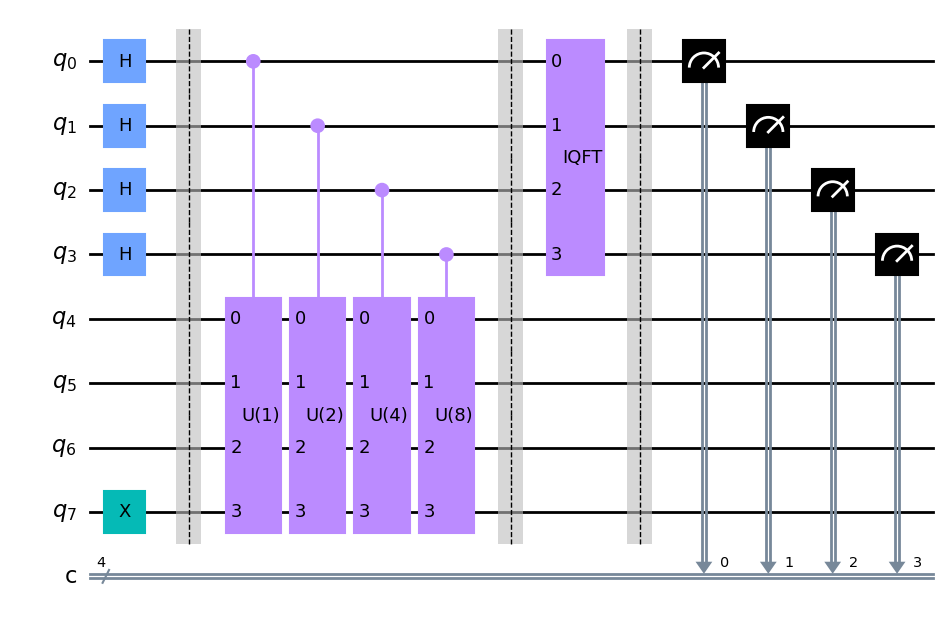

In [13]:
# shors11py
n = 4; m = 4

qc = period_finder(n, m, a)
qc.draw(output='mpl')

/home/developer/.local/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:226: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


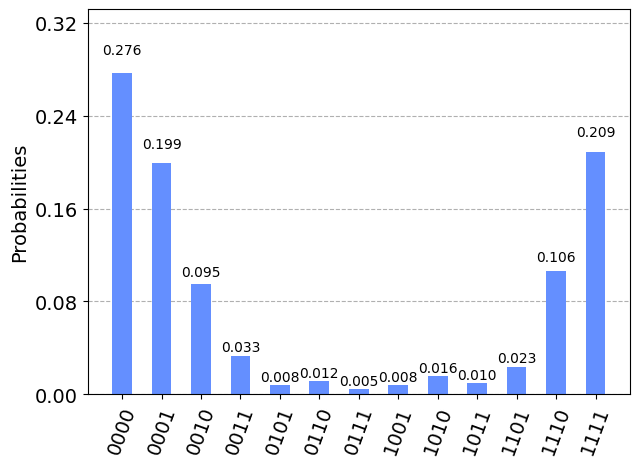

In [14]:
# shors12.py
simulator = Aer.get_backend('qasm_simulator')
counts = execute(qc, backend=simulator).result().get_counts(qc)

plot_histogram(counts)

In [15]:
# shors13.py
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	4	5	6	7	8	9	10	11	12	13	14	15	

In [16]:
# shors14.py
# convert and add binary periods to list
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

periods=[]
print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')
    periods.append(measured_value)

Measured periods:	0	4	5	6	7	8	9	10	11	12	13	14	15	

In [17]:
# shors15.py
factors = set()

for x in periods:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

P = 3
Q = 5

 3 x 5 = 15, True


In [18]:
# shors16.py
_, priv_key = rsa(P, Q)
print("Using RSA and Shor's Algorithm,",
      f"you determine the private key to be:\n\t{priv_key}")

Using RSA and Shor's Algorithm, you determine the private key to be:
	(23, 15)


In [19]:
# shors17.py
dec_str = decode(code, priv_key)
print(f"You learn that the decrypted listing is {dec_str}!")

You learn that the decrypted listing is GFIG!
